In [1]:
import os
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import itertools

### 用pandas讀取訓練數據

In [2]:
df = pd.read_csv('./data/labeledTrainData.tsv' , sep = '\t' , escapechar = '\\')
print('Number of reviews: {}'.format(len(df)))
df.head()

Number of reviews: 25000


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


### 對影評數據做預處理，有以下步驟：

1. 去掉html標簽
1. 移除標點
1. 切分成詞
1. 去掉停用詞(停用詞其實就是一些使句子更通順的詞，在分析中我們通常都會忽略這些停用詞)
1. 重組為新的句子

In [3]:
df['review'][1000]

"I watched this movie really late last night and usually if it's late then I'm pretty forgiving of movies. Although I tried, I just could not stand this movie at all, it kept getting worse and worse as the movie went on. Although I know it's suppose to be a comedy but I didn't find it very funny. It was also an especially unrealistic, and jaded portrayal of rural life. In case this is what any of you think country life is like, it's definitely not. I do have to agree that some of the guy cast members were cute, but the french guy was really fake. I do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it's just too annoying."

In [4]:
# 去掉HTML標簽的數據
example = BeautifulSoup(df['review'][1000] , 'html.parser').get_text()
example

"I watched this movie really late last night and usually if it's late then I'm pretty forgiving of movies. Although I tried, I just could not stand this movie at all, it kept getting worse and worse as the movie went on. Although I know it's suppose to be a comedy but I didn't find it very funny. It was also an especially unrealistic, and jaded portrayal of rural life. In case this is what any of you think country life is like, it's definitely not. I do have to agree that some of the guy cast members were cute, but the french guy was really fake. I do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it's just too annoying."

In [5]:
# 去掉標點符號
example_letters = re.sub(r'[^a-zA-Z]' , ' ' , example)
example_letters

'I watched this movie really late last night and usually if it s late then I m pretty forgiving of movies  Although I tried  I just could not stand this movie at all  it kept getting worse and worse as the movie went on  Although I know it s suppose to be a comedy but I didn t find it very funny  It was also an especially unrealistic  and jaded portrayal of rural life  In case this is what any of you think country life is like  it s definitely not  I do have to agree that some of the guy cast members were cute  but the french guy was really fake  I do have to agree that it tried to have a good lesson in the story  but overall my recommendation is that no one over   watch it  it s just too annoying '

In [6]:
words = example_letters.lower().split()
words

['i',
 'watched',
 'this',
 'movie',
 'really',
 'late',
 'last',
 'night',
 'and',
 'usually',
 'if',
 'it',
 's',
 'late',
 'then',
 'i',
 'm',
 'pretty',
 'forgiving',
 'of',
 'movies',
 'although',
 'i',
 'tried',
 'i',
 'just',
 'could',
 'not',
 'stand',
 'this',
 'movie',
 'at',
 'all',
 'it',
 'kept',
 'getting',
 'worse',
 'and',
 'worse',
 'as',
 'the',
 'movie',
 'went',
 'on',
 'although',
 'i',
 'know',
 'it',
 's',
 'suppose',
 'to',
 'be',
 'a',
 'comedy',
 'but',
 'i',
 'didn',
 't',
 'find',
 'it',
 'very',
 'funny',
 'it',
 'was',
 'also',
 'an',
 'especially',
 'unrealistic',
 'and',
 'jaded',
 'portrayal',
 'of',
 'rural',
 'life',
 'in',
 'case',
 'this',
 'is',
 'what',
 'any',
 'of',
 'you',
 'think',
 'country',
 'life',
 'is',
 'like',
 'it',
 's',
 'definitely',
 'not',
 'i',
 'do',
 'have',
 'to',
 'agree',
 'that',
 'some',
 'of',
 'the',
 'guy',
 'cast',
 'members',
 'were',
 'cute',
 'but',
 'the',
 'french',
 'guy',
 'was',
 'really',
 'fake',
 'i',
 'do'

In [7]:
# 去停用詞
stopwords = [line.rstrip() for line in open('./stopwords.txt')]
words_nostop = []
for w in words:
    if w not in stopwords: 
        words_nostop.append(w)
words_nostop

['watched',
 'movie',
 'late',
 'night',
 'late',
 'pretty',
 'forgiving',
 'movies',
 'stand',
 'movie',
 'worse',
 'worse',
 'movie',
 'suppose',
 'comedy',
 'didn',
 'funny',
 'unrealistic',
 'jaded',
 'portrayal',
 'rural',
 'life',
 'country',
 'life',
 'agree',
 'guy',
 'cast',
 'cute',
 'french',
 'guy',
 'fake',
 'agree',
 'lesson',
 'story',
 'recommendation',
 'watch',
 'annoying']

In [8]:
eng_stopwords = set(stopwords)

def clean_text(text):
    # 去掉HTML標簽的數據
    text = BeautifulSoup(text , 'html.parser').get_text()
    
    # 去掉標點符號
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # 去停用詞
    words = text.lower().split()
    words_nostop = []
    for w in words:
        if w not in eng_stopwords: 
            words_nostop.append(w)
            
    return ' '.join(words)

In [9]:
df['review'][1000]

"I watched this movie really late last night and usually if it's late then I'm pretty forgiving of movies. Although I tried, I just could not stand this movie at all, it kept getting worse and worse as the movie went on. Although I know it's suppose to be a comedy but I didn't find it very funny. It was also an especially unrealistic, and jaded portrayal of rural life. In case this is what any of you think country life is like, it's definitely not. I do have to agree that some of the guy cast members were cute, but the french guy was really fake. I do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it's just too annoying."

In [10]:
clean_text(df['review'][1000])

'i watched this movie really late last night and usually if it s late then i m pretty forgiving of movies although i tried i just could not stand this movie at all it kept getting worse and worse as the movie went on although i know it s suppose to be a comedy but i didn t find it very funny it was also an especially unrealistic and jaded portrayal of rural life in case this is what any of you think country life is like it s definitely not i do have to agree that some of the guy cast members were cute but the french guy was really fake i do have to agree that it tried to have a good lesson in the story but overall my recommendation is that no one over watch it it s just too annoying'

### 清洗數據添加到dataframe裡

In [11]:
df['clean_review'] = df.review.apply(clean_text)
df.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin...",the classic war of the worlds by timothy hines...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager nicholas bell g...
3,3630_4,0,It must be assumed that those who praised this...,it must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy and wondrously unpretentious s...


### 抽取bag of words特徵(用sklearn的CountVectorizer)

In [12]:
# 對每個詞出現的次數進行排序，取前5000個最常出現的詞，並用5000個維度去表示1個詞
vectorizer = CountVectorizer(max_features = 5000) 
train_data_features = vectorizer.fit_transform(df.clean_review).toarray()
train_data_features.shape

(25000, 5000)

In [13]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 訓練分類器

C:\Users\peng\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for testing dataset : 0.858
Recall for testing dataset : 0.862
Precision for testing dataset : 0.851


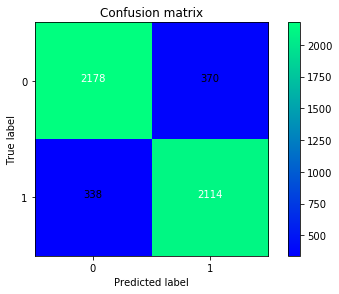

In [14]:
X_train , X_test , y_train , y_test = train_test_split(train_data_features , df.sentiment , test_size = 0.2 , random_state = 0)

LR_model = LogisticRegression()
LR_model = LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)

print('Accuracy for testing dataset : {:.3f}'.format((cnf_matrix[1 , 1] + cnf_matrix[0 , 0]) / cnf_matrix.sum()))
print('Recall for testing dataset : {:.3f}'.format(cnf_matrix[1 , 1] / (cnf_matrix[1 , 0] + cnf_matrix[1 , 1])))
print('Precision for testing dataset : {:.3f}'.format(cnf_matrix[1 , 1] / (cnf_matrix[0 , 1] + cnf_matrix[1 , 1])))

# Plot non-normalized confusion matrix
class_names = [0 , 1]
plot_confusion_matrix(cnf_matrix ,
                      classes = class_names ,
                      title = 'Confusion matrix')
plt.show()

### 接下來利用word2vector抽取特徵，把上述的步驟重新再來一次

In [15]:
df = pd.read_csv('./data/unlabeledTrainData.tsv', sep = '\t', escapechar = '\\')
print('Number of reviews: {}'.format(len(df)))
df.head()

Number of reviews: 50000


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


In [16]:
df['clean_review'] = df['review'].apply(clean_text)
df.head()

,id,review,clean_review
0,9999_0,"Watching Time Chasers, it obvious that it was ...",watching time chasers it obvious that it was m...
1,45057_0,I saw this film about 20 years ago and remembe...,i saw this film about years ago and remember i...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba...",minor spoilersin new york joan barnard elvire ...
3,7161_0,I went to see this film with a great deal of e...,i went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m...",yes i agree with everyone on this site this mo...


In [17]:
review_part = df['clean_review']
review_part.shape

(50000,)

In [18]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') # 並不是單純的分詞，根本是分句

def split_sentences(review):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = [clean_text(s) for s in raw_sentences]
    return sentences
review_part = review_part.apply(split_sentences)

sentences = []
for sentence in review_part:
    sentences.extend(sentence)

In [19]:
sentences_list = []
for sentence in sentences:
    sentences_list.append(nltk.word_tokenize(sentence)) # 這是就是真的分詞啦!!

Word2Vec的參數設置:
-  sentences：可以是一個list
-  sg： 用於設置訓練算法，默認為0，對應CBOW算法(基於上下文去預測一個詞)；sg=1則采用skip-gram算法(基於一個詞去預測上下文)。
-  size：是指特征向量的維度，默認為100。大的size需要更多的訓練數據,但是效果會更好. 推薦值為幾十到幾百。
-  window：表示當前詞與預測詞在一個句子中的最大距離是多少
-  alpha: 是學習速率
-  seed：用於隨機數發生器。與初始化詞向量有關。
-  min_count: 可以對字典做截斷. 詞頻少於min_count次數的單詞會被丟棄掉, 默認值為5
-  max_vocab_size: 設置詞向量構建期間的RAM限制。如果所有獨立單詞個數超過這個，則就消除掉其中最不頻繁的一個。每一千萬個單詞需要大約1GB的RAM。設置成None則沒有限制。

-  workers參數控制訓練的並行數。
-  hs: 如果為1則會采用hierarchica·softmax技巧。如果設置為0（defaut），則negative sampling會被使用。
-  negative: 如果>0,則會采用negativesamp·ing，用於設置多少個noise words
-  iter： 叠代次數，默認為5

In [20]:
# 設定詞向量訓練的參數
num_features = 300    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
model_name = '{}features_{}minwords_{}context.model'.format(num_features , min_word_count , context)

In [21]:
model = Word2Vec(sentences_list ,  
                 workers = num_workers , 
                 size = num_features , 
                 min_count = min_word_count, 
                 window = context)

# If you don't plan to train the model any further, calling init_sims will make the model much more memory-efficient.
model.init_sims(replace = True)

# It can be helpful to create a meaningful model name and save the model for later use. You can load it later using Word2Vec.load()
model.save(os.path.join('.' , 'models' , model_name))

In [22]:
print(model.doesnt_match(['man' , 'woman' , 'child' , 'kitchen']))

kitchen


C:\Users\peng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
C:\Users\peng\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:858: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [23]:
model.most_similar('boy')

C:\Users\peng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('girl', 0.7136349081993103),
 ('kid', 0.6966495513916016),
 ('lad', 0.6444034576416016),
 ('brat', 0.5790923833847046),
 ('owl', 0.5676288604736328),
 ('teenager', 0.5624595880508423),
 ('dog', 0.558837890625),
 ('son', 0.542203426361084),
 ('priest', 0.5355404019355774),
 ('dad', 0.5214924812316895)]

In [24]:
model.most_similar('bad')

C:\Users\peng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('terrible', 0.6870288252830505),
 ('horrible', 0.6555653214454651),
 ('crappy', 0.6502566337585449),
 ('awful', 0.6454183459281921),
 ('lousy', 0.6375600099563599),
 ('good', 0.635956883430481),
 ('lame', 0.5984287858009338),
 ('cheesy', 0.5950378179550171),
 ('stupid', 0.5922435522079468),
 ('horrid', 0.56467604637146)]

In [25]:
df = pd.read_csv('./data/labeledTrainData.tsv' , sep = '\t' , escapechar = '\\')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [26]:
stopwords = stopwords

def clean_text(text):
    text = BeautifulSoup(text , 'html.parser').get_text()
    text = re.sub(r'[^a-zA-Z]' , ' ' , text)
    words = text.lower().split()
    for w in words:
        if w not in stopwords: 
            words_nostop.append(w)
    return words


def to_review_vector(review):
    global word_vec  
    review = clean_text(review)
    word_vec = np.zeros([1 , 300])
    for word in review:
        if word in model:
            word_vec += np.array([model[word]]) # 把review中的詞替換成vector後再加起來平均，代表一個文本只會產生一個300維的vector
    return pd.Series(word_vec.mean(axis = 0))

train_data_features = df['review'].apply(to_review_vector)
train_data_features.head()

C:\Users\peng\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\peng\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-5.211788,-11.335078,4.792433,-4.147452,-0.056204,5.658121,4.588565,3.819156,-4.425441,3.799887,...,-2.317324,-8.765022,-2.395037,-1.165839,-5.719965,2.193597,3.420818,-1.367639,-1.405565,-3.836697
1,-2.498362,-1.738613,2.902485,-1.572224,-1.226645,1.077215,0.226404,1.225721,-0.094061,-2.736747,...,0.856142,-4.015483,-1.909256,-1.279437,-3.654569,-0.039802,2.831032,-1.221848,1.653629,-0.519991
2,-1.378565,-1.774903,3.055238,-3.133496,-3.808399,2.482267,1.050456,0.905782,-1.129574,1.426688,...,-0.606060,3.567223,-0.641269,-5.106323,1.846757,5.708487,-5.335167,-0.300722,7.632250,7.275739
3,-7.235034,-4.340986,5.296387,-5.026325,-2.437872,4.244495,1.600768,-2.397268,-1.525988,0.644491,...,-3.647582,-5.690122,-1.213695,-0.508236,-2.454050,6.454435,0.819543,-1.620495,4.087259,0.614703
4,-5.404754,-6.064138,1.552591,-1.728254,-3.834445,2.137757,0.368849,-0.015507,-4.074298,0.917299,...,-2.279252,-0.378197,2.572881,-3.119746,-1.304525,7.922727,-1.991513,0.624434,4.517706,1.749543


C:\Users\peng\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for testing dataset : 0.877
Recall for testing dataset : 0.885
Precision for testing dataset : 0.867


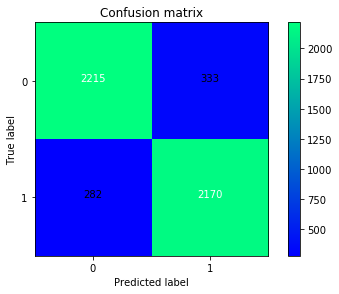

In [27]:
X_train , X_test , y_train , y_test = train_test_split(train_data_features , df.sentiment , test_size = 0.2 , random_state = 0)

# 使用邏輯回歸來訓練
LR_model = LogisticRegression()
LR_model = LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)

print('Accuracy for testing dataset : {:.3f}'.format((cnf_matrix[1 , 1] + cnf_matrix[0 , 0]) / cnf_matrix.sum()))
print('Recall for testing dataset : {:.3f}'.format(cnf_matrix[1 , 1] / (cnf_matrix[1 , 0] + cnf_matrix[1 , 1])))
print('Precision for testing dataset : {:.3f}'.format(cnf_matrix[1 , 1] / (cnf_matrix[0 , 1] + cnf_matrix[1 , 1])))

# Plot non-normalized confusion matrix
class_names = [0 , 1]
plot_confusion_matrix(cnf_matrix ,
                      classes = class_names ,
                      title = 'Confusion matrix')
plt.show()

使用word2vector的效果還是比bag of words還好一點!!<br />
在Accuracy、Recall、Precision上都有所提升 